# Cell Transmission Models for Networks

In another Notebook the basic of Cell Transmission Model was presented: demand and supply are computed based on densities, flows are compute based on demand and supply and finally the densities are updated based on the computed flows. If you don't have an idea of what these terms are, please refer to the Cell-transmission-model notebook first.

In that notebook, the network part was not detailed. One of the nicest feature of the cell transmission model is the possibility to extend for nodes. Most of the cells, referred here as "regular cells", has one upstream cell and one downstream cell. In that case flows are computed through the minimum of demand of upstream cells and supply of downstream cell. However, at the nodes we may have a different case. In signalized intersection, a given cell can multiple downstream cells (one for each downstream link) as well as multiple upstream cells (one for each upstream link). This also happens on freeways, with on-ramps joining a freeway can be described as merge and an off-ramp exit as a diverge.

With appropriate node models, we can compute the flows on the cells adjacent to the node and thereby simulate network traffic. First three types of nodes are described. Later, we will simulate the traffic in a small network with time-dependent demands.

# Definitions and notation

From now on, whenever we are talking about the demand of a link it refers to the demand of last cell of the link. Similarly, supply refers to the supply of the first cell of a link. For a given node $n$, $I_v$ refers to the set of incoming links and $O_v$ the set of outgoing links of node $v$. For example, a diverge node has one incoming iink and two outgoing links and a merge node has two incoming links and one outgoing link. They also can be referred to as upstream links for incoming links and as downstream links for outgoing links. 

In general, the necessary inputs for a node model are:

* Demand $D_i$ of all incoming links at every time step.
* Supply $S_o$ of all outgoing links at every time step.
* turning ratio $t_{io}$ for every pair incoming-outgoing link. This can be time-dependent but in general it is assumed to be constant.

The outputs are the flows for each pair incoming-outgoing link $q_{io}$. The basic requirement of a node model are the following:

* $ 0 \leq q_i = \sum_{o \in O_v} q_{io} \leq D_i$
* $ 0 \leq q_o = \sum_{i \in I_v} q_{io} \leq S_i$
* $ q_{io} = q_i t_{io} $

Following the model and codes for merge and diverge nodes are presented. First the diverge and merge models presented in the original paper is presented Cell-transmission-model part II (1995). Later, a different merge model is presented based on ideas in (Ni, Leonard, 2005) and with some further properties derived in (Jin, 2010) and the differences are highlighted for a simple case. 


# Diverge nodes

It is considered a node with one upstream link, indexed as 1, and two downstream links indexed as 2 and 3. As mentioned, we need to have a turning ratio from every pair of upstream and downstream link. In this case, we need to know $t_{1,2}$ and $t_{1,3}$. The inputs are upstream demand, $D_1$ and downstream supplies, $S_2$ and $S_3$. Assuming that first-in-first-out discipline will hold in the upstream link, the flows are computed as follows:

$$q_1 = \min \{D_1, \frac{S_2}{t_{12}}, \frac{S_3}{t_{13}} \} $$
$$ q_{12}=q_2 = q_1 t_{12} $$
$$ q_{13} = q_3 = q_1 t_{13} $$

Therefore it is quite straightforward. The function below compute flows for link 1, 2, 3 given demand supplies and turning ratios.

In [32]:
import numpy
import pylab

def compute_diverge_flows(D1, S2, S3, t12, t13):
    q1 = min(D1,S2/t12,S3/t13)
    q2 = q1*t12
    q3 = q1*t13
    return q1, q2, q3

We can play with the values just to have an idea on how it works. Let's assume the numbers used are normalized so we can disregard units and the upstream link has capacity $1$. If the supply of downstream links is also $1$, only the flow will be always equal to the upstream demand. Let's play around:

In [33]:
print(compute_diverge_flows(0.3,1, 1, 0.5, 0.5))
print(compute_diverge_flows(0.6,1, 1, 0.5, 0.5))
print(compute_diverge_flows(1.0,1, 1, 0.5, 0.5))
print(compute_diverge_flows(0.6,1, 1, 0.6, 0.4))

(0.3, 0.15, 0.15)
(0.6, 0.3, 0.3)
(1.0, 0.5, 0.5)
(0.6, 0.36, 0.24)


In all function calls to compute_diverge_flows $S_2=S_3=1.0$ with increasing demands. In the first three the turning ratios were evenly split and in the last case a different split ratio was considered. That was reflected on the second and third output. Keeping $t_2=0.6$ and $t_3=0.4$ the following calls exploit the cases where the supply is smaller:

In [34]:
print(compute_diverge_flows(0.8,0.8, 0.4, 0.6, 0.4))
print(compute_diverge_flows(0.8,0.8, 0.2, 0.6, 0.4))
print(compute_diverge_flows(0.8,0.4, 0.4, 0.6, 0.4))

(0.8, 0.48, 0.32000000000000006)
(0.5, 0.3, 0.2)
(0.6666666666666667, 0.4, 0.2666666666666667)


In the first case the demands were smaller but still $q_1=D_1$. In the second case, even though the turning ratio to link 3 is smaller, that link had a very small and defined the flows as $q_3=S_3$. In the last case, the demand the lower demand on link $2$ defined the overall outflow as $q_2=S_2$. Also observe that in all cases the prescribed turning ratio holds.

# Merge Node

The merge node has two upstream links indexed as 1 and 2 and one downstram link as 3. In the case of merges we are implictly assuming turning ratio are all 1 ($t_{12}=1$, $t_{13}=1$). The flows are computed as follows:

$$ q_3 = \min \{D_1+D_2, S_3 \} $$
$$ q_1 = \min \{ D_1, S_3 \frac{D_1}{D_1+D_2} \} $$
$$ q_2 = \min \{ D_2, S_3 \frac{D_2}{D_1+D_2} \} $$

If $D_1+D_2$ does not exceed the downstream supply, $S_3$ the flow is driven by upstream demands or else the downstream flow is determined by downstream supply. In that latter case, the flow in each upstream link is proportional by their demands. The code below implements this merge model. 


In [35]:
def compute_merge_flows(D1, D2, S3):
    if D1+D2 == 0:
        return (0.0, 0.0, 0.0)
    
    q3 = min(D1+D2,S3)
    q1 = min(D1,S3*D1/(D1+D2))
    q2 = min(D2,S3*D2/(D1+D2))
    
    return q1, q2, q3

print(compute_merge_flows(0.5, 0.5, 1.0))
print(compute_merge_flows(0.5, 0.5, 0.8))
print(compute_merge_flows(0.6, 0.4, 0.9))
print(compute_merge_flows(0.4, 0.6, 0.9))

(0.5, 0.5, 1.0)
(0.4, 0.4, 0.8)
(0.54, 0.36000000000000004, 0.9)
(0.36000000000000004, 0.54, 0.9)


Observe in the first two calls all upstream demands are served. In the last two, the sum of upstream demand exceeds downstream supply, and the flows in the upstream links are smaller than their respective demands. Now we can run cell transmission model for networks containing merges and diverges. This model does not cover more general nodes, but for most of the cases it is possible to convert a general node with multiple upstream and downstream links into a series of merge-diverge nodes (of course, sometimes with slightly different results). Before going into the merge models, a class for link cell transmission model is coded below based on the code presented in the previous notebook about cell transmission model. It will be useful to extend to general networks.

In [36]:
class CTMLink:
    def __init__(self, num_cells, dt, dx, total_time,vf, w, kj, n):
        self.num_cells = num_cells
        self.dt = dt
        self.dx = dx
        self.total_time = total_time
        self.total_steps = int(total_time/self.dt)

        self.vf = vf
        self.w = w
        self.kj = kj
        self.n = n

        self.densities = numpy.zeros((num_cells, self.total_steps+1))
        self.flows = numpy.zeros((num_cells+1, self.total_steps))

        self.demands = [0.0 for i in range(num_cells)]
        self.supplies = [0.0 for i in range(num_cells)]

    def run_step(self, step, inflow, outflow):
        for i in range(self.num_cells):
            ki = self.densities[i,step]
            di = self.D(ki)
            si = self.S(ki)

            self.demands[i] = di
            self.supplies[i] = si
        
        for i in range(self.num_cells+1):
            if i==0:
                q = inflow
            elif i==self.num_cells:
                q = outflow
            else:
                q = min(self.demands[i-1], self.supplies[i] )


            self.flows[i,step] = q

        for i in range(self.num_cells):
            r = self.dt/self.dx

            self.densities[i,step+1] = self.densities[i,step] + r*(self.flows[i,step]-self.flows[i+1,step])
        
    def get_demand(self, step):
        return self.D(self.densities[self.num_cells-1,step])
    
    def get_supply(self, step):
        return self.S(self.densities[0,step])
        
    def Q(self, k):
        return min(self.vf*k, self.w*(self.n*self.kj -k))

    def D(self, k):
        return min(self.vf*k, self.n*self.kj*self.vf*self.w/(self.vf+self.w))

    def S(self, k):
        return min(self.w*(self.n*self.kj-k),self.n*self.kj*self.vf*self.w/(self.vf+self.w) )
    


Before going to merge and diverge numerical experiments, first let's see how this class "CTMLink" works. The class helps to encapsulate all the variables and parameter related to a link which in this case we can define a link for different number of cells and fundamental diagram parameters. It is also an input the time step used for the simulation and the total time. In the code below the experiment is similar to the original CTM Python Notebook. However, instead of portion with less number of lanes it is just assumed that the downstream supply is constant at $S_d=0.3veh/s$. The upstream demand up to $150s$ is $d=0.45 veh/hs$ and thereafter $d=0.3veh/s$. 

A object of this class is instantiated with the appropriate parameters. At each step the downstream demand and upstream supply is computed. The flow at boundaries are computed externally (that is, the for below is computing the flows at the boundaries and not the link model). After, the method for link update is called and all the cells are updated based on current density and boundary flows.

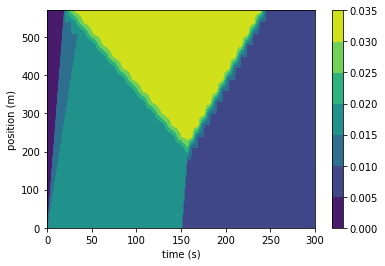

In [37]:

test_link = CTMLink(20, 1, 30, 300,30, 6, 0.1, 1)

for i in range(300):
    s = test_link.get_supply(i)
    d = test_link.get_demand(i)
    
    if i < 150:
        inflow = min(s, 0.45)
    else:
        inflow = min(s, 0.3)
    
    outflow = min(d, 0.4)
    
    test_link.run_step(i, inflow, outflow)
    
times = [1.0*i for i in range(301)]
positions = [30*i for i in range(20)]

cp = pylab.contourf(times, positions, test_link.densities)
pylab.colorbar(cp)
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

The result resembles our last experiment. The code above also makes clear the role of the node model. In the for-loop the boundary flows were computed based on some rules (inflow = .../ outflow =...) and later the rest of the link state is update based on this boundary flows. The node model replaces exactly that step.

We are going to apply that to the simplest network containing one diverge and one merge, often referred as to as diverge-merge network as the Figure below.

<img src="divergemerge.png">

The last link downstream has a very small capacity and it will trigger congestion on the two reaching to it and eventually reaching the first link. Then demand ceases and the whole network becomes uncongested.

Similar to the previous experiment, the demand starts high and later decreases.

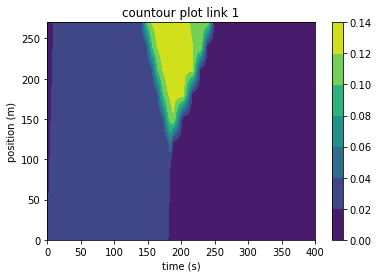

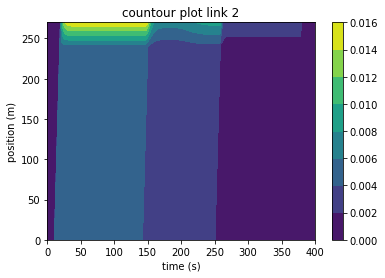

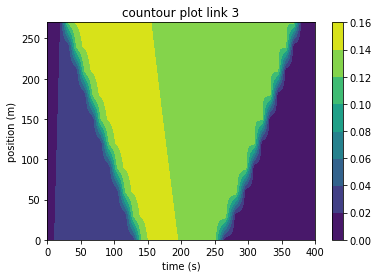

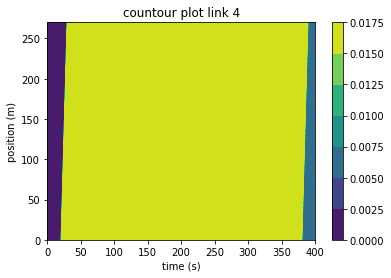

In [38]:
total_steps = 400

link_1 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 2)
link_2 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 2)
link_3 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 2)
link_4 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 1) #last link is the bottleneck with only 1 lane

beta_12 = 0.2
beta_13 = 0.8


demands = [0.8 for _ in range(total_steps)]
for j in range(180,total_steps):
    demands[j] = 0.2

for step in range(total_steps):
    d1 = link_1.get_demand(step)
    s2 = link_2.get_supply(step)
    s3 = link_3.get_supply(step)
    
    d2 = link_2.get_demand(step)
    d3 = link_3.get_demand(step)
    
    s4 = link_4.get_supply(step)
    d4 = link_4.get_demand(step)
    
    
    g1, f2, f3 = compute_diverge_flows(d1, s2, s3, beta_12, beta_13)
    
    g2, g3, f4 = compute_merge_flows(d2, d3, s4)
    
    g4 = d4

    
    link_1.run_step(step, demands[step],g1)
    link_2.run_step(step, f2, g2)
    link_3.run_step(step, f3,g3)
    link_4.run_step(step, f4,g4)

times = [1.0*i for i in range(total_steps+1)]
positions = [30*i for i in range(10)]

cont_levels = [0.0, 0.005, 0.01, 0.015, 0.02, 0.08, 0.12, 0.16, 0.2]

cp = pylab.contourf(times, positions, link_1.densities)
pylab.title("countour plot link 1")
pylab.colorbar(cp)
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

cp = pylab.contourf(times, positions, link_2.densities)
pylab.colorbar(cp)
pylab.title("countour plot link 2")
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

cp = pylab.contourf(times, positions, link_3.densities)
pylab.colorbar(cp)
pylab.title("countour plot link 3")
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

cp = pylab.contourf(times, positions, link_4.densities)
pylab.colorbar(cp)
pylab.title("countour plot link 4")
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()


In our hypothetical example the congestion started at the merge triggering congestion at links 2 and 3. At around 150s the congestion has reached the very first link. The demand decreased at $t=200s$ and then we can see the shock-wave propagating forward on links 1,2,3 just after that. So, with few lines of code we could simulate a network that contain all basic building blocks of a complex traffic network.

Though not going further in details - a forthcoming notebook will address that -, let's take a look on how the node models can impact the overall results and should be carefully chosen or modeled for the intended application. The merge model presented is proportional to the traffic $D(k)$ taken from the most downstream link. It means that whever total demand ($D_1+D_2$) exceeds downstream supply ($S_3$), the congestion will spread for both upstream links. However observe that the dynamics is somehow different in both links and the congestion in link 2 and the density on the congested area does not increase as much as in the other link. The first graph below plots the outflow of links 2 and 3. The second graph plots the density at each cell at $t=50s$. Observe the very last cell (n=10) has a slightly higher density.

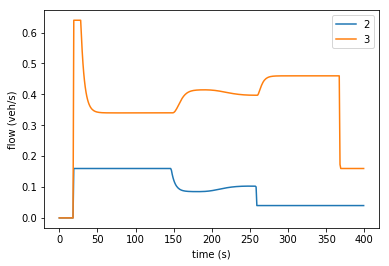

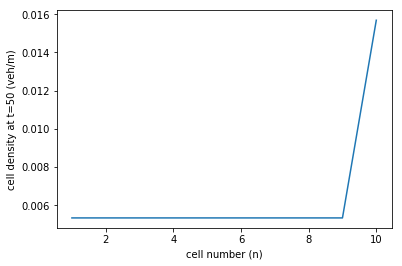

In [39]:
pylab.plot([i for i in range(total_steps)], link_2.flows[9,:], label=2)
pylab.plot([i for i in range(total_steps)], link_3.flows[9,:], label=3)
pylab.xlabel("time (s)")
pylab.ylabel("flow (veh/s)")
pylab.legend(loc=1)
pylab.show()

pylab.plot(range(1,11), link_2.densities[:,50])
pylab.xlabel("cell number (n)")
pylab.ylabel("cell density at t=50 (veh/m)")
pylab.show()

In [40]:
def compute_merge_flows_fair_merging(D1, D2, C1, C2, S3):
    theta = S3/(C1 + C2)
    
    if D1+D2 <= S3:
        theta = 1.0
    else:
        t1 = (S3-D2)/C1
        t2 = (S3-D1)/C2
        t12 = S3/(C1+C2)
        
        if t1*C2 > D2:
            theta = t1
        elif t2*C1 > D1:
            theta = t2
        else:
            theta = t12
        
       
    
    q3 = min(D1+D2,S3)
    q1 = min(D1, theta*C1)
    q2 = min(D2, theta*C2)
    
    return (q1, q2, q3)

print(compute_merge_flows_fair_merging(0.5, 0.5, 1.0, 1.0, 1.0))
print(compute_merge_flows_fair_merging(0.5, 0.5, 1.0, 1.0, 0.8))
print(compute_merge_flows_fair_merging(0.6, 0.4, 1.0, 1.0, 0.9))
print(compute_merge_flows_fair_merging(0.4, 0.6, 1.0, 1.0, 0.9))

(0.5, 0.5, 1.0)
(0.4, 0.4, 0.8)
(0.5, 0.4, 0.9)
(0.4, 0.5, 0.9)


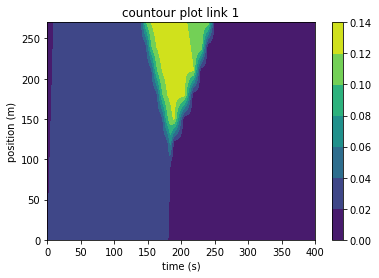

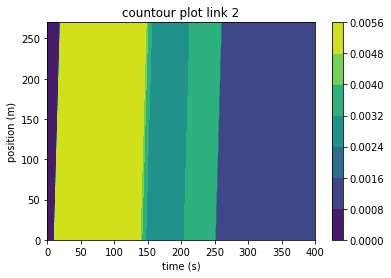

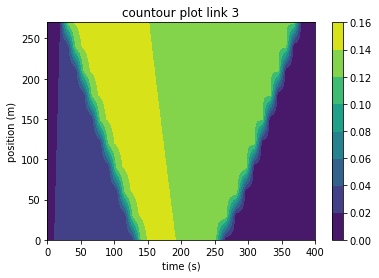

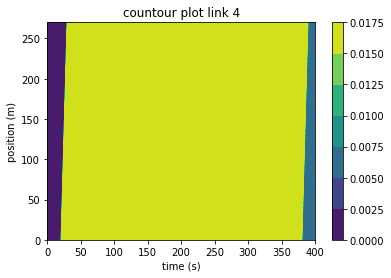

In [41]:
total_steps = 400

link_1_r2 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 2)
link_2_r2 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 2)
link_3_r2 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 2)
link_4_r2 = CTMLink(10, 1, 30, total_steps,30, 6, 0.1, 1) #last link is the bottleneck with only 1 lane

beta_12 = 0.2
beta_13 = 0.8


demands = [0.8 for _ in range(total_steps)]
for j in range(180,total_steps):
    demands[j] = 0.2

for step in range(total_steps):
    d1 = link_1_r2.get_demand(step)
    s2 = link_2_r2.get_supply(step)
    s3 = link_3_r2.get_supply(step)
    
    d2 = link_2_r2.get_demand(step)
    d3 = link_3_r2.get_demand(step)
    
    s4 = link_4_r2.get_supply(step)
    d4 = link_4_r2.get_demand(step)
    
    
    g1, f2, f3 = compute_diverge_flows(d1, s2, s3, beta_12, beta_13)
    
    g2, g3, f4 = compute_merge_flows_fair_merging(d2, d3,0.5, 0.5, s4)
    
    g4 = d4

    
    link_1_r2.run_step(step, demands[step],g1)
    link_2_r2.run_step(step, f2, g2)
    link_3_r2.run_step(step, f3,g3)
    link_4_r2.run_step(step, f4,g4)

times = [1.0*i for i in range(total_steps+1)]
positions = [30*i for i in range(10)]

cp = pylab.contourf(times, positions, link_1_r2.densities)
pylab.title("countour plot link 1")
pylab.colorbar(cp)
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

cp = pylab.contourf(times, positions, link_2_r2.densities)
pylab.colorbar(cp)
pylab.title("countour plot link 2")
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

cp = pylab.contourf(times, positions, link_3_r2.densities)
pylab.colorbar(cp)
pylab.title("countour plot link 3")
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

cp = pylab.contourf(times, positions, link_4_r2.densities)
pylab.colorbar(cp)
pylab.title("countour plot link 4")
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()


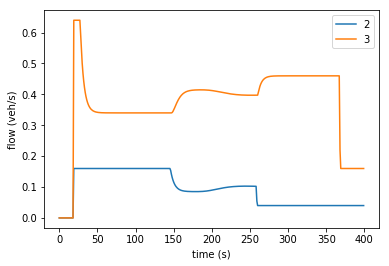

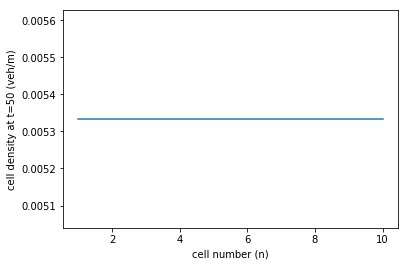

In [42]:
pylab.plot([i for i in range(total_steps)], link_2_r2.flows[9,:], label=2)
pylab.plot([i for i in range(total_steps)], link_3_r2.flows[9,:], label=3)
pylab.xlabel("time (s)")
pylab.ylabel("flow (veh/s)")
pylab.legend(loc=1)
pylab.show()

pylab.plot(range(1,11), link_2_r2.densities[:,50])
pylab.xlabel("cell number (n)")
pylab.ylabel("cell density at t=50 (veh/m)")
pylab.show()

Though the flow graphs are quite similar, observe the density becomes homogeneous at link 2 and congestion only happens in link 3 which then spreads to link 1. In the very first node model we used, the density at very last cell was different from all other cells.

# References

Daganzo, Carlos F. "The cell transmission model, part II: network traffic." Transportation Research Part B: Methodological 29.2 (1995): 79-93.

Ni, Daiheng, and John D. Leonard II. "A simplified kinematic wave model at a merge bottleneck." Applied Mathematical Modelling 29.11 (2005): 1054-1072.

Jin, Wen-Long. "Continuous kinematic wave models of merging traffic flow." Transportation research part B: methodological 44.8-9 (2010): 1084-1103.